In [1]:
import psycopg2
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from collections import defaultdict
from scipy import stats
import numpy as np
from calendar import monthrange

In [2]:
conn = psycopg2.connect(database="postgres",
                        host="localhost",
                        user="postgres",
                        password="postgres",
                        port="5432")
cursor = conn.cursor()

In [3]:
cursor.execute("""
SELECT
    DATE_TRUNC('month',doe_parsed) AS doe_month,
    device_report_product_code,
    event_type,
    COUNT(*)
FROM mdrfoi
JOIN device d on mdrfoi.mdr_report_key = d.mdr_report_key
WHERE
    doe_parsed >= '2011-01-01'::date
    AND doe_parsed < '2020-03-01'::date
    AND event_type in ('D', 'IN', 'IL', 'IJ', 'M')
    AND device_report_product_code in ('MAF', 'NIQ', 'PNY')
GROUP BY doe_month, event_type, device_report_product_code
ORDER BY doe_month, event_type, device_report_product_code;
""")
rows = cursor.fetchall()

In [4]:
groups = defaultdict(lambda: [[], [], 0])
for date, device, event, count in rows:
    event = 'I' if event in ('IN', 'IL', 'IJ') else event
    groups[(device, event)][0].append(date)
    mr = monthrange(int(date.year), int(date.month))
    groups[(device, event)][1].append(count)
    groups[(device, event)][2] += count

for k in groups:
    groups[k][0] = np.array(groups[k][0])
    groups[k][1] = np.array(groups[k][1])

In [22]:
def plot_linear_regression(dates, y, label, ax=None, color=None, linestyle=None):
    slope, intercept, r_value, p_value, std_err = stats.linregress([d.toordinal() for d in dates], y)
    # Calculate a fit line
    x_num = mdates.date2num(dates)
    trend = np.polyfit(x_num, y, 1)
    fit = np.poly1d(trend)

   
    x_fit = np.linspace(x_num.min(), x_num.max())
    if ax:
        ax.plot(mdates.num2date(x_fit), fit(x_fit), label=f'{label}, r={r_value:.2f}', color=color, linestyle=linestyle)
    else:
        plt.plot(mdates.num2date(x_fit), fit(x_fit), label=f'{label}, r={r_value:.2f}', linestyle=linestyle)

    return r_value


In [23]:
def plot_for_device(device_code, device_name, combined_mi=False):
    size = 12
    maf_m_x, maf_m_y, maf_m_total = groups[(device_code, 'M')]
    maf_i_x, maf_i_y, maf_i_total  = groups[(device_code, 'I')]
    maf_d_x, maf_d_y, maf_d_total  = groups[(device_code, 'D')]

    plot_linear_regression(maf_m_x, maf_m_y, f'{device_name}, Malfunction', linestyle='solid')
    plot_linear_regression(maf_i_x, maf_i_y, f'{device_name}, Injury', linestyle='dashed')
    plot_linear_regression(maf_d_x, maf_d_y, f'{device_name}, Death', linestyle='dashdot')
    if combined_mi:
        plot_linear_regression(maf_d_x, maf_m_y + maf_i_y, f'{device_name}, Malfunction + Injury', linestyle='dotted')

    plt.scatter(
        maf_m_x,
        maf_m_y,
        label=f'{device_name}, Malfunction, {maf_m_total}',
        marker='o',
        s=size,
    )
    plt.scatter(
        maf_i_x,
        maf_i_y,
        label=f'{device_name}, Injury, {maf_i_total}',
        marker='^',
        s=size,
    )
    plt.scatter(
        maf_d_x,
        maf_d_y,
        label=f'{device_name}, Death, {maf_d_total}',
        marker='v',
        s=size,
    )
    if combined_mi:
        plt.scatter(
            maf_m_x,
            maf_m_y + maf_i_y,
            label=f'{device_name}, Malfunction + Injury, {maf_m_total + maf_i_total}',
            marker='x',
            s=size,
        )
    plt.xlabel('Time')
    plt.ylabel('Count Per Month')
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    # plt.grid(axis = 'y')
    plt.show()

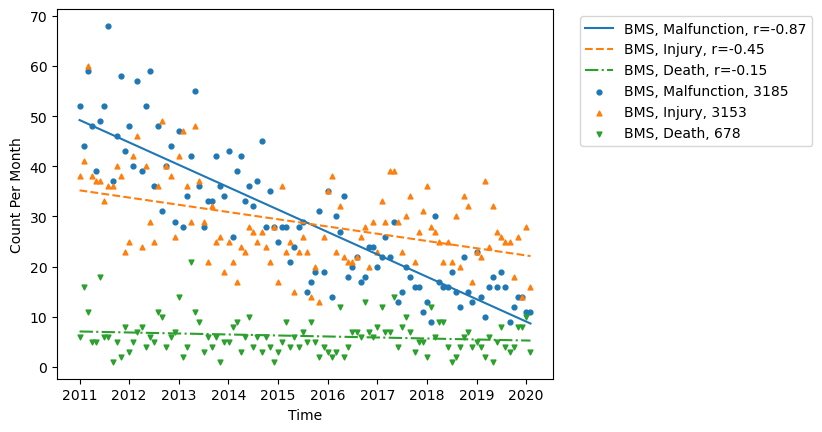

In [24]:
# MAF -> BMS
# NIQ -> DES
# PNY -> BAS
plot_for_device('MAF', 'BMS')

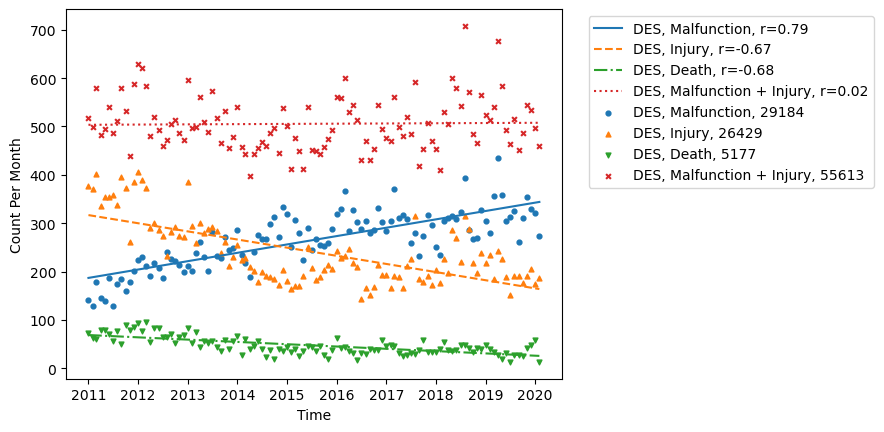

In [25]:
plot_for_device('NIQ', 'DES', combined_mi=True)

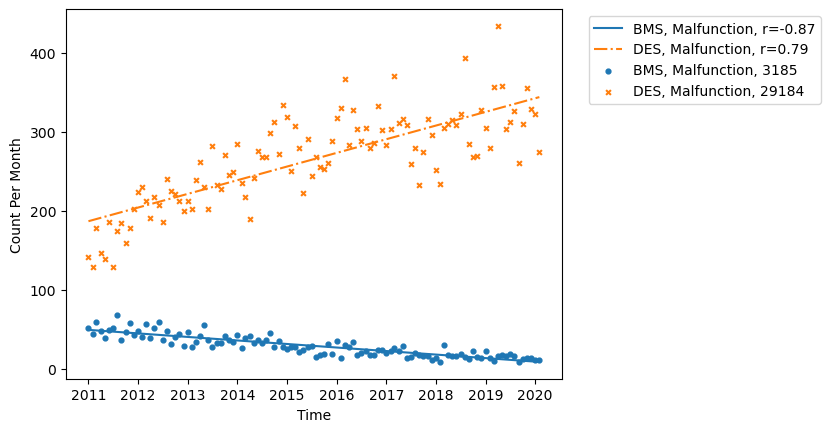

In [26]:
size = 12

maf_m_x, maf_m_y, maf_m_total = groups[('MAF', 'M')]
niq_m_x, niq_m_y, niq_m_total = groups[('NIQ', 'M')]

plot_linear_regression(maf_m_x, maf_m_y, 'BMS, Malfunction', linestyle='solid')
plot_linear_regression(niq_m_x, niq_m_y, 'DES, Malfunction', linestyle='dashdot')

plt.scatter(
    maf_m_x,
    maf_m_y,
    label=f'BMS, Malfunction, {maf_m_total}',
    marker='o',
    s=size,
)
plt.scatter(
    niq_m_x,
    niq_m_y,
    label=f'DES, Malfunction, {niq_m_total}',
    marker='x',
    s=size,
)

plt.xlabel('Time')
plt.ylabel('Count Per Month')
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
# plt.grid(axis = 'y')
plt.show()

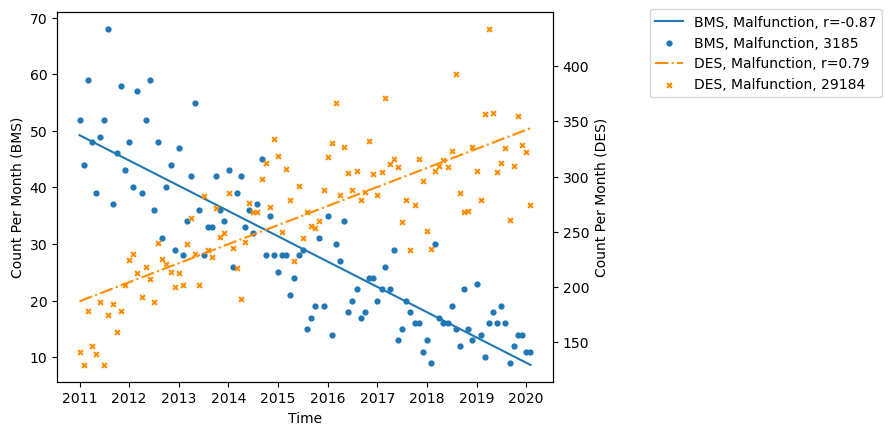

In [29]:
size = 12
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

maf_m_x, maf_m_y, maf_m_total = groups[('MAF', 'M')]
niq_m_x, niq_m_y, niq_m_total = groups[('NIQ', 'M')]

plot_linear_regression(maf_m_x, maf_m_y, 'BMS, Malfunction', ax=ax1, linestyle='solid')
plot_linear_regression(niq_m_x, niq_m_y, 'DES, Malfunction', ax=ax2, color='darkorange', linestyle='dashdot')

ax1.scatter(
    maf_m_x,
    maf_m_y,
    label=f'BMS, Malfunction, {maf_m_total}',
    marker='o',
    s=size,
)
ax2.scatter(
    niq_m_x,
    niq_m_y,
    label=f'DES, Malfunction, {niq_m_total}',
    marker='x',
    color='darkorange',
    s=size,
)

ax1.set_xlabel('Time')
ax1.set_ylabel('Count Per Month (BMS)')
ax2.set_ylabel('Count Per Month (DES)')
fig.legend(bbox_to_anchor=(1.04, 0.9), loc="upper left")

# plt.grid(axis = 'y')
plt.show()